In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
def load_dataset(data_folder):
    X, y, filenames = [], [], []
    categories = ["class_0", "class_1"]
    image_count = {category: 0 for category in categories}  # Initialize count for each category
    for category_id, category in enumerate(categories):
        category_folder = os.path.join(data_folder, category)
        # Count the number of images
        num_images = len(os.listdir(category_folder))
        image_count[category] = num_images  # Update count for this category
        for i in range(1, num_images + 1):  # Start from 1 instead of 0
            img_path = os.path.join(category_folder, f"{i}.jpg")
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize images to the same size
                    X.append(img)
                    y.append(category_id)
                    filenames.append(f"{category}_{i}.jpg")  # Store filenames for stratified split
    X = np.array(X)
    y = np.array(y)
    return X, y, filenames, image_count


# Load the dataset
data_folder = "dataset4/train"
X, y, filenames, image_count = load_dataset(data_folder)


# Show the count of images
for category, count in image_count.items():
    print(f"Number of images in {category}: {count}")


Number of images in class_0: 8089
Number of images in class_1: 3623


In [3]:
def load_dataset(data_folder):
    X, y, filenames = [], [], []
    categories = ["class_0", "class_1"]
    image_count = {category: 0 for category in categories}  # Initialize count for each category
    for category_id, category in enumerate(categories):
        category_folder = os.path.join(data_folder, category)
        # Get the list of image files in the folder
        image_files = [f for f in os.listdir(category_folder) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        # Count the number of images
        num_images = len(image_files)
        image_count[category] = num_images  # Update count for this category
        for img_file in image_files:
            img_path = os.path.join(category_folder, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize images to the same size
                X.append(img)
                y.append(category_id)
                filenames.append(img_file)  # Store filenames for stratified split
    X = np.array(X)
    y = np.array(y)
    return X, y, filenames, image_count

# Load the dataset
data_folder = "dataset4/train"
X, y, filenames, image_count = load_dataset(data_folder)

# Show the count of images
for category, count in image_count.items():
    print(f"Number of images in {category}: {count}")

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Number of images in class_0: 8089
Number of images in class_1: 3623
Shape of X: (11712, 224, 224, 3)
Shape of y: (11712,)


In [4]:
from sklearn.utils import resample
X_majority = X[y == 0]
X_minority = X[y == 1]

# Upsample minority class
X_minority_resampled = resample(X_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(X_majority),  # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
X_resampled = np.concatenate((X_majority, X_minority_resampled))
y_resampled = np.concatenate((np.zeros(len(X_majority)), np.ones(len(X_minority_resampled))))

# Shuffle the resampled data
shuffle_index = np.random.permutation(len(X_resampled))
X_resampled, y_resampled = X_resampled[shuffle_index], y_resampled[shuffle_index]

# Print the count of images after resampling
print("\nAfter resampling:")
print("Number of images in class 0:", np.sum(y_resampled == 0))
print("Number of images in class 1:", np.sum(y_resampled == 1))



After resampling:
Number of images in class 0: 8089
Number of images in class 1: 8089


In [5]:
# Split the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Print the count of training and testing data
print("\nNumber of images in training set:", len(X_train))
print("Number of images in testing set:", len(X_test))


Number of images in training set: 12942
Number of images in testing set: 3236


In [6]:
# Define a generator for batch processing
def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        yield X[indices], y[indices]

# Create the GCN model
input_shape = X_train[0].shape
num_classes = 2  # Assuming 2 classes

In [7]:
# Define the GCN model
def create_gcn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # Initial convolutional layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Convolutional layer
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'), # Convolutional layer
        layers.Flatten(),  # Flatten the feature maps
        layers.Dense(32, activation='relu'),  # Fully connected layer
        layers.Dropout(0.5),  # Dropout layer for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Create the GCN model
input_shape = X_train[0].shape
num_classes = 2  # Assuming 2 classes
gcn_model = create_gcn_model(input_shape, num_classes)



In [8]:
# Compile the model
gcn_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [9]:
# Train the model using the generator
batch_size = 16
num_batches = len(X_train) // batch_size

history = gcn_model.fit(data_generator(X_train, y_train, batch_size),
                        steps_per_epoch=num_batches,
                        epochs=10,
                        validation_data=(X_test, y_test))

Epoch 1/10
808/808 [==============================] - 148s 173ms/step - loss: 71.7586 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.4858
Epoch 2/10
808/808 [==============================] - 136s 168ms/step - loss: 0.6932 - accuracy: 0.4953 - val_loss: 0.6937 - val_accuracy: 0.4858
Epoch 3/10
808/808 [==============================] - 136s 169ms/step - loss: 0.6933 - accuracy: 0.4965 - val_loss: 0.6930 - val_accuracy: 0.5142
Epoch 4/10
808/808 [==============================] - 136s 169ms/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6935 - val_accuracy: 0.4858
Epoch 5/10
808/808 [==============================] - 136s 169ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6933 - val_accuracy: 0.4858
Epoch 6/10
808/808 [==============================] - 136s 169ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.4858
Epoch 7/10
808/808 [==============================] - 136s 169ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6938 

In [10]:
# Evaluate the model on the test dataset
test_loss, test_acc = gcn_model.evaluate(test_dataset)
print('Test Accuracy:', test_acc)

102/102 [==============================] - 7s 68ms/step - loss: 0.6935 - accuracy: 0.4858
Test Accuracy: 0.4857849180698395


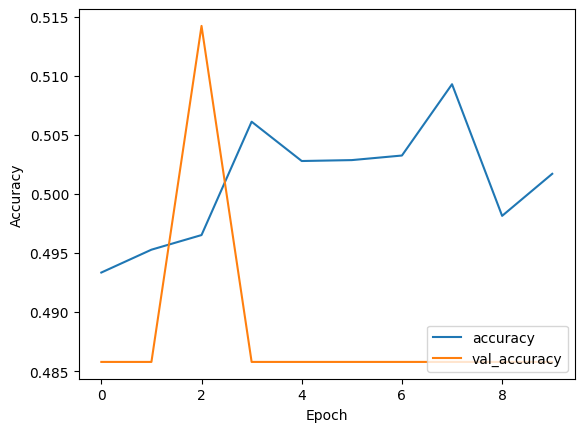

In [21]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Save only the model weights
gcn_model.save_weights("gcn_model_weights.h5")

# Save only the model architecture
with open("gcn_model_architecture.json", "w") as json_file:
    json_file.write(gcn_model.to_json())


1/1 [==============================] - 0s 69ms/step


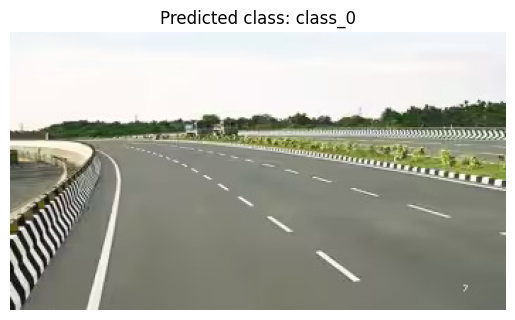

1/1 [==============================] - 0s 26ms/step


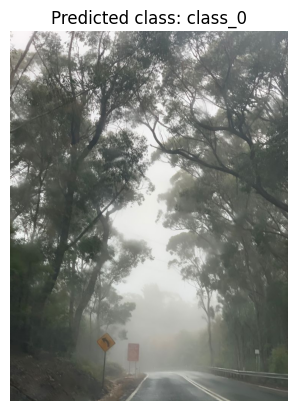

1/1 [==============================] - 0s 24ms/step


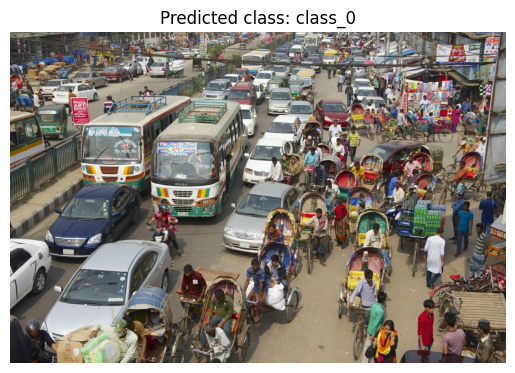

1/1 [==============================] - 0s 36ms/step


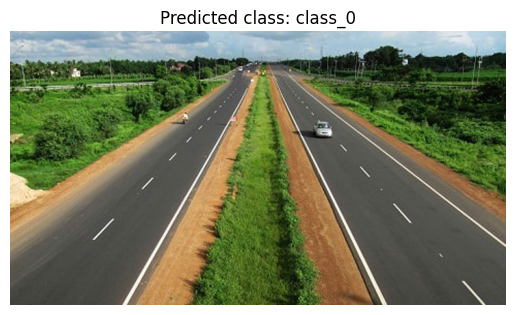

1/1 [==============================] - 0s 18ms/step


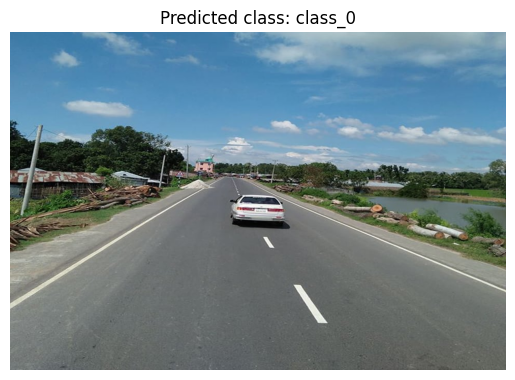

1/1 [==============================] - 0s 18ms/step


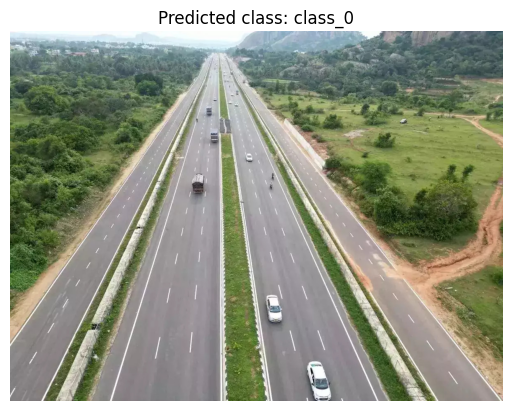

1/1 [==============================] - 0s 21ms/step


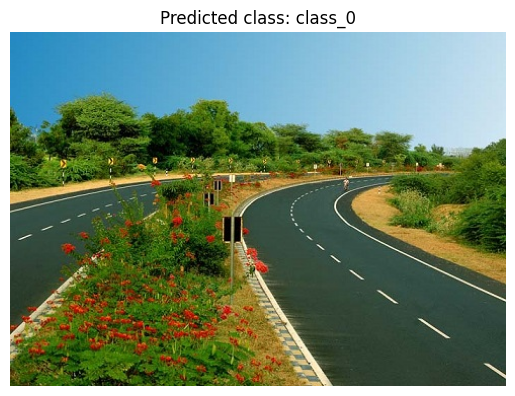

1/1 [==============================] - 0s 25ms/step


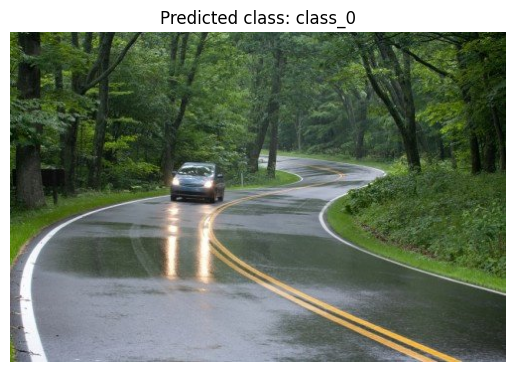

Image 1.jpg: Predicted class - class_0
Image 2.jpg: Predicted class - class_0
Image 3.jpg: Predicted class - class_0
Image 4.jpg: Predicted class - class_0
Image 5.jpg: Predicted class - class_0
Image 6.jpg: Predicted class - class_0
Image Jaipur-bypass-ROAD.jpg: Predicted class - class_0
Image main-qimg-c894ac4269d24f66e4b1676e1d3f291c-lq.jpg: Predicted class - class_0


In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json

# Load the model architecture
with open("gcn_model_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()

# Reconstruct the model architecture
gcn_model = model_from_json(loaded_model_json)

# Load the saved weights into the model
gcn_model.load_weights("gcn_model_weights.h5")

# Predict on new images
def predict_on_images(gcn_model, image_folder):
    predictions = []
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize images to the same size as the training images
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            pred = gcn_model.predict(img)
            predicted_class = np.argmax(pred[0])  # Get the index of the maximum value
            predictions.append((filename, predicted_class))
            # Display the image with its predicted class
            plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
            plt.title(f"Predicted class: {'class_0' if predicted_class == 0 else 'class_1'}")
            plt.axis('off')
            plt.show()
    return predictions

# Test on new images
new_images_folder = "dataset4/test"  # Updated folder name
predictions = predict_on_images(gcn_model, new_images_folder)
for filename, predicted_class in predictions:
    print(f"Image {filename}: Predicted class - {'class_0' if predicted_class == 0 else 'class_1'}")
